In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import numpy as np
import torch
import matplotlib.pyplot as plt

import random
import re
import requests

In [2]:
# obtaining list of school names

link = "https://www.collegevine.com/schools/hub/data/static"

# avoid printing f.text; Large file
f = requests.get(link)

university_list = re.findall("\"rankings\":.+?\"bucket\":\"(\d*)\",\"key\":\"overall\".+?\"slug\":\"(.+?)\"", f.text)


print(university_list[0])

('305', 'abilene-christian-university')


In [3]:
university_list = sorted(university_list, key = lambda pair: int(pair[0]))

gap = 0

for x in range(len(university_list)):
    university_list[x] = [int(university_list[x][0]), university_list[x][1]]
    if x+1 != int(university_list[x][0]) - gap:
        gap += 1
        print(university_list[x-1:x+1])

print(len(sorted(university_list, key = lambda pair: pair[0])))

top_400 = university_list[0:400]

[[287, 'bryant-university'], [289, 'milwaukee-school-of-engineering-msoe']]
[[403, 'ohio-wesleyan-university'], [405, 'brigham-young-university-hawaii']]
[[647, 'university-of-indianapolis'], [649, 'franklin-college']]
[[676, 'st-edward-s-university'], [678, 'high-point-university']]
[[799, 'university-of-nebraska-omaha-uno'], [801, 'university-of-toledo']]
[[852, 'rocky-mountain-college-rmc'], [854, 'hardin-simmons-university']]
[[867, 'johnson-c-smith-university'], [869, 'spring-arbor-university']]
[[1053, 'tabor-college'], [1055, 'wells-college']]
[[1064, 'hope-international-university'], [1066, 'university-of-northwestern-st-paul']]
[[1191, 'concordia-college-new-york'], [1193, 'methodist-university']]
[[1264, 'notre-dame-de-namur-university'], [1266, 'felician-university']]
[[1349, 'dakota-state-university'], [1351, 'southern-university-at-new-orleans']]
1506


In [4]:
# get links for all schools

college_links = []

for school in top_400:
    name = school[1]
    college_links.append("https://www.collegevine.com/schools/" 
                            + name.replace(" ", "-") 
                            +  "/essay-prompts")

print(college_links[0])

https://www.collegevine.com/schools/stanford-university/essay-prompts


In [5]:
def get_bag(docs, word_list):
    out_list = []

    for doc in docs:
        stop_words = set(stopwords.words("english") + ["etc", "'s", ""])
        filtered_list = []

        seperated_words = word_tokenize(doc[1])

        for word in seperated_words:
            # currently deciding to filter out punctuation
            # use ascii or something this is insane
            if word[-1] in [".", ",", ";", ":", "?", "!", "*", "’", "–", "(", ")", "/", "~", "‘", "``"]:
                word = word[:-1]
            if word not in stop_words:
                # currently ignoring capitalization
                filtered_list.append(word.lower())
        
        # filtered_list = [word for word in doc[1].split() if word not in stop_words]
        tagged_list = nltk.pos_tag(filtered_list)
        
        lemmatizer = WordNetLemmatizer()
        lemmatized_list = []

        for word in tagged_list:
            pos = ""
            # print(word[1][0])
            if word[1][0] == "J":
                pos = "a"
            elif word[1][0] == "N":
                pos = "n"
            elif word[1][0] == "V":
                pos = "v"
            elif word[1][0] == "R":
                pos = "r"
            else:
                # print("uh oh")
                lemmatized_list.append(word[0])
                continue
            
            lemmatized_list.append(lemmatizer.lemmatize(word[0], pos=pos))

        word_list += lemmatized_list
        out_list.append(lemmatized_list)
        
    return out_list, word_list

In [6]:
# access links and create general word bag


# currently trying to use list instead of dictionary to store prompts and their corresponding index
allprompts = []
prompt_matrix = []

potential_issues = []
index = 0
prompts = []
has_common_app = False
word_list = []

for link_index in range(len(college_links)):
    has_common_app = False
    link = college_links[link_index]
    f = requests.get(link)

    noprompts = re.search("<h2>", f.text)

    if not bool(noprompts):
        prompts = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)
        select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)

        if prompts == []:
            potential_issues.append(link)
            continue

        if prompts[-1][0] == "Common App Personal Essay":
            has_common_app = True
            prompts = prompts[:-1]
            select_prompts = select_prompts[:-7]

        if select_prompts != []:
            i = 0
            while i < len(prompts):
                # print(len(prompts[x]))
                if "Select-A-Prompt" in prompts[i][0]:
                    del prompts[i]
                else:
                    i += 1

            if has_common_app:
                for x in select_prompts:
                    prompts.append(("Select-A-Prompt", x))

        # checks again, but now for schools with only common app essay
        if prompts == []:
            continue
        
        # prompts is a list of prompts for the current school.
        # each prompt is in a tuple with their title first and then the prompt
        allprompts.append([link_index, prompts])

        prompts, word_list = get_bag(prompts, word_list)
        
        # school_rank = top_400[link_index][0]
        
        for j in range(len(prompts)):
            prompt_matrix.append([index, j] + prompts[j])
        
        index += 1


In [7]:
print(prompt_matrix[5])

[0, 5, 'what', 'historical', 'moment', 'event', 'wish', 'could', 'witness']


In [8]:
print(allprompts[0])

[0, [('Intellectual Passion Short Response', 'The Stanford community is deeply curious and driven to learn in and out of the classroom. Reflect on an idea or experience that makes you genuinely excited about learning.*'), ('Roommate Short Response', "Virtually all of Stanford's undergraduates live on campus. Write a note to your future roommate that reveals something about you or that will help your roommate – and us – get to know you better.*"), ('Share Something Meaningful Short Response', 'Tell us about something that is meaningful to you and why.*'), ('Societal Challenge Short Response', 'What is the most significant challenge that society faces today?'), ('Summer Activities Short Response', 'How did you spend your last two summers?'), ('Historical Moment Short Response', 'What historical moment or event do you wish you could have witnessed?'), ('Extracurricular Short Response', 'Briefly elaborate on one of your extracurricular activities, a job you hold, or responsibilities you ha

In [9]:
print(len(word_list), len(set(word_list)))

# print(word_list[0:100])

random.seed(111)

word_list = list(set(word_list))

# random.shuffle(word_list)

print(word_list[0:100])

12458 2455
['snack', 'throughout', 'this', 'positively', 'ephesian', 'suggestion', 'qualify', 'vassar', 'thought', 'interruption', 'gather', 'dealt', 'introspection', 'seattle', 'connection', 'civil', 'affair', 'pepperdine', 'star', 'olin', 'game', '1895', 'for', 'nation', 'roman', 'pick', 'particularly', 'globally-minded', 'whatever', 'equips', 'currently', 'playlist', 'colorful', 'cooperatively', 'ground', 'creative', 'relax', '2-3', 'undivided', 'usd', 'tulane', 'n', 'thus', 'tradition', 'mechanical', 'anticipate', 'empower', 'descend', 'well-informed', 'spectacular', 'engagement', 'discourage', 'ad', 'mission', 'math', 'call', 'cause', 'tuesday', 'president', 'dyson', 'have', 'literature', 'expose', 'providence', 'great', 'rely', 'below', 'song/piece', 'ready', 'perfect', 'illinois', 'clinic', 'town', 'westphal', 'sphere', 'showcase', 'nonfictional—who', 'power', '2014', 'pursuing', 'audience', 'respond', 'element', 'dish', 'production', 'medicine', 'guilty', 'creativity', 'charact

In [10]:
# turn prompts into vectors

for prompt_ind in range(len(prompt_matrix)):
    curr_freq = dict(zip(word_list, [0 for x in range(len(word_list))]))
    for word in prompt_matrix[prompt_ind][2:]:
        curr_freq[word] += 1
    prompt_matrix[prompt_ind] = prompt_matrix[prompt_ind][0:2] + list(curr_freq.values())

In [11]:
prompt_tensor = torch.tensor(prompt_matrix, dtype=torch.float32)

print(prompt_tensor.shape)

torch.manual_seed(333)
U, S, V = torch.pca_lowrank(prompt_tensor[:,2:], q=None, center=True, niter=3)

pca_axes = torch.matmul(prompt_tensor[:,2:], V[:, :7])

torch.Size([728, 2457])


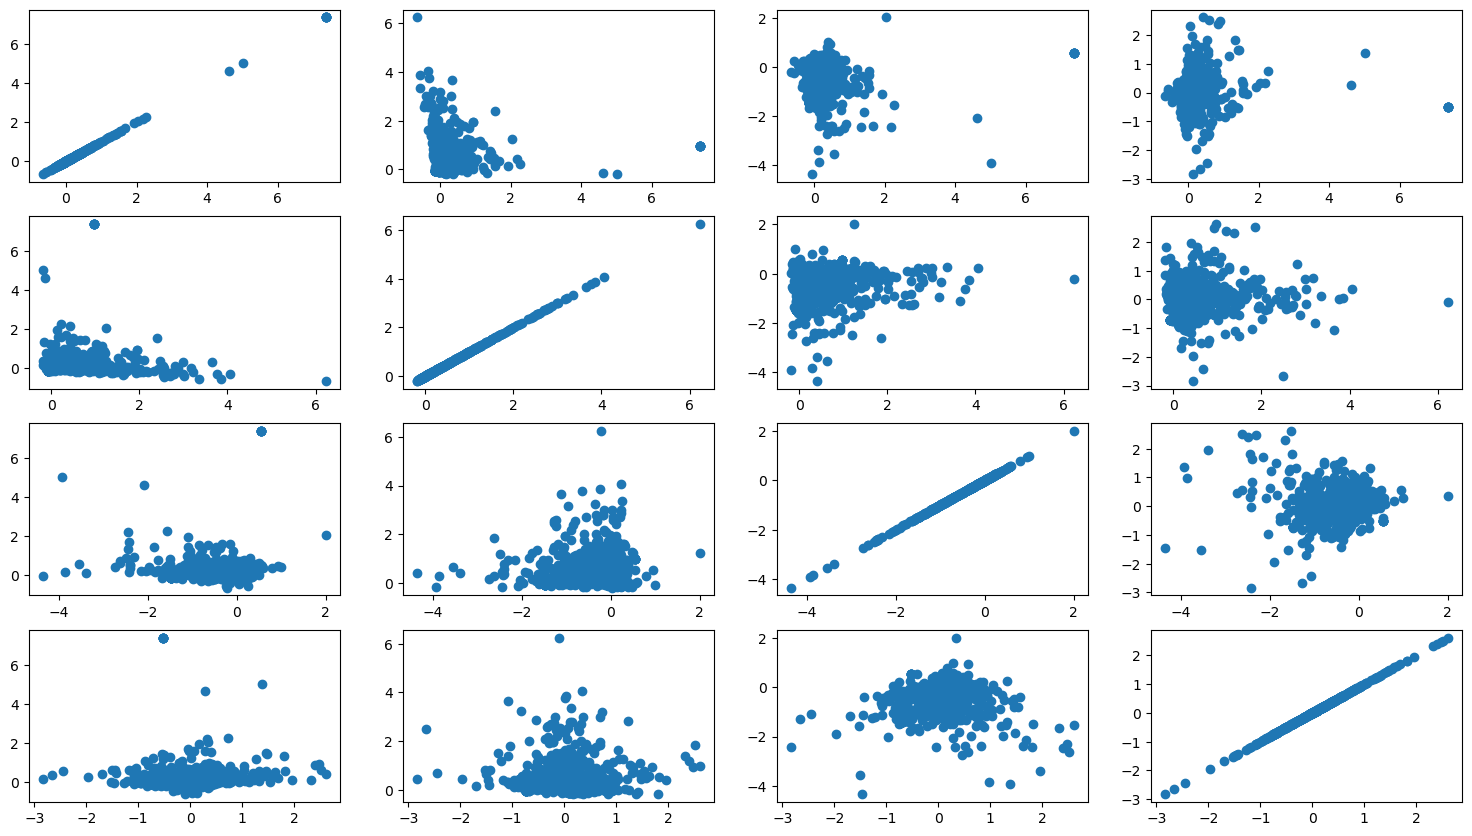

In [12]:
num_comps = 4

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(0, num_comps):
    for j in range(0, num_comps):
        axs[i][j].scatter(pca_axes[:,i], pca_axes[:,j])

In [13]:
# k-means for any dim, points is list of vectors in n-dim

def find_distances(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            if curr_dist < min_dist:
                min_dist = curr_dist
                min_ind = j
        
        # print(min_ind)
        clusters[min_ind].append(curr_point)

    return clusters


def k_means(points, k, labels = 0):

    random.seed(333)
    centroids = random.sample(points, k)

    for center_num in range(k):
        centroids[center_num] = np.asarray(centroids[center_num])
    
    
    equal_means = 0
    clusters = []

    while equal_means < k:
        clusters = find_distances(points, centroids, labels)
        
        for i in range(k):
            mean = sum(np.asarray(clusters[i])) / len(clusters[i])
            dim = labels
            curr_equal_means = True
            while (dim < len(points[0])) and curr_equal_means:
                if (mean[dim] != centroids[i][dim]):
                    centroids[i] = mean
                    curr_equal_means = False
                dim += 1
            
            if dim == len(points[0]):
                equal_means += 1
    
    return clusters

67


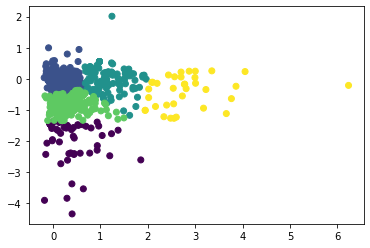

In [14]:
pca_points = [[pca_axes[:,1][i], pca_axes[:,2][i]] for i in range(len(pca_axes[:,1]))]

pca_clusters = k_means(pca_points, 5)

print(len(pca_clusters[0]))

pca_clusters_graph = []

for c in range(len(pca_clusters)):
    for x in pca_clusters[c]:
        pca_clusters_graph.append(x + [c])

pca_clusters_graph = np.asarray(pca_clusters_graph)

plt.scatter(pca_clusters_graph[:,0], pca_clusters_graph[:,1], c = pca_clusters_graph[:,2])

In [15]:
all_clusters = k_means(prompt_matrix, 40, labels = 2)

for x in all_clusters[0:10]:
    print(len(x))

1
1
1
16
2
19
5
42
9
46


In [16]:
n = 5
for x in all_clusters[n:n+1]:
    print(len(x))
    for i in range(0, len(x), 4):
        school_ind = x[i][0]
        prompt_ind = x[i][1]
        print(top_400[allprompts[school_ind][0]], allprompts[school_ind][1][prompt_ind])

19
[4, 'princeton-university'] ('A.B. Applicants or Undecided Applicants Short Response', 'As a research institution that also prides itself on its liberal arts curriculum, Princeton allows students to explore areas across the humanities and the arts, the natural sciences, and the social sciences. What academic areas most pique your curiosity, and how do the programs offered at Princeton suit your particular interests? (Please respond in about 250 words)')


[13, 'northwestern-university'] ('MMSS Program Short Response', 'Which social science question or problem interests you most?')


[47, 'barnard-college'] ('Bold Questions Short Response', 'At Barnard, academic inquiry starts with bold questions. What are some of the bold questions you have pondered that get you excited and why do they interest you? Tell us how you would explore these questions at Barnard.')


[94, 'brandeis-university'] ('Additional Info Short Response', 'The Brandeis community is a diverse group of critical thinke